In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from astropy.io import ascii
from astropy.io import fits

%load_ext autoreload
%autoreload 2

from matplotlib import rc

rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

# Constants and definitions:
lmc_distance = 50e3


def Absolute_to_Apparent(AbsoluteMag, distance):
    return AbsoluteMag + 5 * (np.log10(distance / 10))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### To run this you'll need a series of CSVs and fits files. 
### These are too large for github but can be found here: 


### Unless you need to rerun reduction and dust extinction you can jump down a few cells.

## Read in and Prepare the Data:

In [7]:
lmc = pd.read_csv("Data/LMC_combined_1_1.csv")

###########
## Reduce #
###########

print(f"Total LMC Sources: {lmc.shape[0]}")

# Drop Nans
lmc = lmc.dropna(
    subset=[
        "uvw2_mag",
        "uvw2_mag_err",
        "uvm2_mag",
        "uvm2_mag_err",
        "uvw1_mag",
        "uvw1_mag_err",
        "Umag",
        "e_Umag",
        "Bmag",
        "e_Bmag",
        "Vmag",
        "e_Vmag",
    ]
)


print(f"After Dropping Nans LMC Sources: {lmc.shape[0]}")


# Saturated Flag
lmc = lmc[
    (lmc.uvm2_saturated == 0) & (lmc.uvw1_saturated == 0) & (lmc.uvw2_saturated == 0)
]


print(f"Keeping Saturated Flag = 0 LMC Sources: {lmc.shape[0]}")


# SSS Flag
lmc = lmc[(lmc.uvm2_sss == 1.0) & (lmc.uvw1_sss == 1.0) & (lmc.uvw2_sss == 1.0)]


print(f"Keeping SSS Flag = 1 LMC Sources: {lmc.shape[0]}")


# Edge Flag
lmc = lmc[(lmc.uvm2_edge == 1.0) & (lmc.uvw1_edge == 1.0) & (lmc.uvw2_edge == 1.0)]


print(f"Keeping Edge Flag = 1 LMC Sources: {lmc.shape[0]}")


# Residual Frac Error
max_resid_error = 0.5
lmc = lmc[
    (np.abs(lmc.uvm2_resid_frac) < max_resid_error)
    & (np.abs(lmc.uvw1_resid_frac) < max_resid_error)
    & (np.abs(lmc.uvw2_resid_frac) < max_resid_error)
]

print(f"Keeping Max Residaul Under {max_resid_error} LMC Sources: {lmc.shape[0]}")

# UVOT - Mag Error
max_mag_error = 0.25
lmc = lmc[
    (lmc.uvm2_mag_err < max_mag_error)
    & (lmc.uvw1_mag_err < max_mag_error)
    & (lmc.uvw2_mag_err < max_mag_error)
]

print(f"Keeping Max UVOT Mag Error Under {max_mag_error} LMC Sources: {lmc.shape[0]}")

# Optical -  Mag Error
max_emag = 0.25
lmc = lmc[
    (lmc.e_Umag < max_mag_error)
    & (lmc.e_Bmag < max_mag_error)
    & (lmc.e_Vmag < max_mag_error)
    & (lmc.e_Imag < max_mag_error)
]

print(f"Remaining LMC Sources: {lmc.shape[0]}")

# Drop sources base on colors:
lmc = lmc.drop(lmc[lmc["uvw1_mag"] - lmc["Umag"] < -3].index).reset_index(drop=True)
lmc = lmc.drop(lmc[lmc["uvw1_mag"] - lmc["Umag"] > 3].index).reset_index(drop=True)
lmc = lmc.drop(lmc[lmc["Umag"] - lmc["Bmag"] < -2].index).reset_index(drop=True)
lmc = lmc.drop(lmc[lmc["Umag"] - lmc["Bmag"] > 2].index).reset_index(drop=True)
lmc = lmc.drop(lmc[lmc["Bmag"] - lmc["Vmag"] < -1].index).reset_index(drop=True)
lmc = lmc.drop(lmc[lmc["Bmag"] - lmc["Vmag"] > 1].index).reset_index(drop=True)
lmc = lmc.drop(lmc[lmc["Vmag"] - lmc["Imag"] < -1].index).reset_index(drop=True)
lmc = lmc.drop(lmc[lmc["Vmag"] - lmc["Imag"] > 1].index).reset_index(drop=True)

print(f"Remaining LMC Sources: {lmc.shape[0]}")

lmc.to_csv("Data/LMC_Reduced.csv", index=False)

Total LMC Sources: 436372
After Dropping Nans LMC Sources: 279274
Keeping Saturated Flag = 0 LMC Sources: 279274
Keeping SSS Flag = 1 LMC Sources: 276799
Keeping Edge Flag = 1 LMC Sources: 272800
Keeping Max Residaul Under 0.5 LMC Sources: 233252
Keeping Max UVOT Mag Error Under 0.25 LMC Sources: 184530
Remaining LMC Sources: 174424
Remaining LMC Sources: 161030


In [9]:
###################
# Dust Correction #
###################

import Dust

lmc_corr = Dust.DustCorrection("Data/LMC_Reduced.csv")

Ignoring Milky Way values from IRSA table for now, check that this is ok.
Using Av/Alambda table generated in Foreground/DustRemoval.ipynb.
Assuming Coordinates are in degrees. No frame assumed.
Assuming all sources in catalog are within the lmc galaxy.
Assuming WCS orgin = 0.
Did not apply dereddening to errors. Check this. 


## ** Start here unless you need to rerun reduction or dust

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from astropy.io import ascii
from astropy.io import fits

%load_ext autoreload
%autoreload 2

from matplotlib import rc

rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

# Constants and definitions:
lmc_distance = 50e3


def Absolute_to_Apparent(AbsoluteMag, distance):
    return AbsoluteMag + 5 * (np.log10(distance / 10))

In [2]:
###############
# M o d e l s #
###############

# These are all in absolute magnitude.

zams_lmc = ascii.read("Data/ZAMS_Z0.006_Vegamag.txt")

she_lmc = ascii.read("Data/stripped_stars_Z0.006_Vegamag.txt")

zams_lmc_uvm2 = Absolute_to_Apparent(zams_lmc["UVM2_spec"], lmc_distance)
zams_lmc_v = Absolute_to_Apparent(zams_lmc["V_spec"], lmc_distance)


zams_lmcAB = ascii.read("Data/ZAMS_Z0.006_ABmag.txt")

she_lmcAB = ascii.read("Data/stripped_stars_Z0.006_ABmag.txt")

zams_lmc_uvm2AB = Absolute_to_Apparent(zams_lmcAB["UVM2_spec"], lmc_distance)
zams_lmc_vAB = Absolute_to_Apparent(zams_lmcAB["V_spec"], lmc_distance)

she_lmc_uvm2AB = Absolute_to_Apparent(she_lmcAB["UVM2"], lmc_distance)
she_lmc_vAB = Absolute_to_Apparent(she_lmcAB["V"], lmc_distance)

In [5]:
def get_colors(x, y, zams_uvm2, zams_v):
    """x is the uvm2-v color of data; y is uvm2"""

    data_x = np.array(x)
    data_y = np.array(y)
    curve_x = np.array(zams_uvm2) - np.array(zams_v)
    curve_y = np.array(zams_uvm2)

    # Interpolate the ZAMS to the y (uvm2) value of the data
    zams_color_ref = np.interp(data_y, np.flip(curve_y, 0), np.flip(curve_x, 0))

    m_map = []
    sizes = []
    alphas = []
    for i in range(len(x)):
        if x[i] < zams_color_ref[i]:
            # c = "#0099b5"
            c = np.array([13, 193, 231]) / 255.0
            s = 5
        if x[i] >= zams_color_ref[i]:
            # c = "#061728"
            c = np.array([9, 7, 52]) / 255.0
            s = 10
        m_map.append(c)
        sizes.append(s)

    return m_map, sizes


def get_blue(x, y, zams_uvm2, zams_v):
    """x is the uvm2-v color of data; y is uvm2"""

    data_x = np.array(x)
    data_y = np.array(y)
    curve_x = np.array(zams_uvm2) - np.array(zams_v)
    curve_y = np.array(zams_uvm2)

    # Interpolate the ZAMS to the y (uvm2) value of the data
    zams_color_ref = np.interp(data_y, np.flip(curve_y, 0), np.flip(curve_x, 0))

    x_sub = []
    y_sub = []
    for i in range(len(x)):
        if x[i] < zams_color_ref[i]:
            x_sub.append(x[i])
            y_sub.append(y[i])

    return x_sub, y_sub


def get_red(x, y, zams_uvm2, zams_v):
    """x is the uvm2-v color of data; y is uvm2"""

    data_x = np.array(x)
    data_y = np.array(y)
    curve_x = np.array(zams_uvm2) - np.array(zams_v)
    curve_y = np.array(zams_uvm2)

    # Interpolate the ZAMS to the y (uvm2) value of the data
    zams_color_ref = np.interp(data_y, np.flip(curve_y, 0), np.flip(curve_x, 0))

    x_sub = []
    y_sub = []
    for i in range(len(x)):
        if x[i] >= zams_color_ref[i]:
            x_sub.append(x[i])
            y_sub.append(y[i])

    return x_sub, y_sub


import matplotlib.colors as colors
from scipy import stats


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

## Actual CMD PLOTS:

In [6]:
#########
# L M C #
#########

# Read in Data:
l = pd.read_csv("Data/LMC_Reduced_DeRed.csv")
lmc_mean_extinction = 0.25  # 0.44

# Define Axes

l_uvm2 = l["uvm2_mag"] + 1.69 - 3.07 * lmc_mean_extinction
l_v = l["vmag"] + 0.02 - lmc_mean_extinction
l_uvm2_v = l_uvm2 - l_v

# Separate based on line:
lx_cand, ly_cand = get_blue(l_uvm2_v, l_uvm2, zams_lmc_uvm2AB, zams_lmc_vAB)
lx_ms, ly_ms = get_red(l_uvm2_v, l_uvm2, zams_lmc_uvm2AB, zams_lmc_vAB)

# Create Main sequence density (Top Cat styling):
lxy_ms = np.vstack([lx_ms, ly_ms])
lz_ms = stats.gaussian_kde(lxy_ms)(lxy_ms)
lidx_ms = lz_ms.argsort()
lx_ms, ly_ms, lz_ms = (
    np.array(lx_ms)[lidx_ms],
    np.array(ly_ms)[lidx_ms],
    np.array(lz_ms)[lidx_ms],
)

In [27]:
# Stellar Data:
iso_path = "Data/LMC_Isolated_2019b.csv"
# iso_path = 'LMC_Isolated_2019.csv'
iso = pd.read_csv(iso_path)

iso = iso[iso["name"] != "lmc-obs45578-835"]

iso_uvm2 = iso["uvm2_mag"] + 1.69 - 3.07 * iso["Av"]
iso_v = iso["Vmag"] + 0.02 - iso["Av"]

iso_uvm2_v = iso_uvm2 - iso_v


wn_path = "Data/LMC_WN3O3_2019.csv"
wn = pd.read_csv(wn_path, comment=";")
wn_uvm2 = wn["uvm2_mag"] + 1.69 - 3.07 * 3.1 * wn["E(B-V)"]
wn_v = wn["Vmag"] + 0.02 - 3.1 * wn["E(B-V)"]
wn_uvm2_v = wn_uvm2 - wn_v

wr_path = "Data/LMC_WR_2019b.csv"
wr = pd.read_csv(wr_path, comment=";")
wr_uvm2 = wr["uvm2_mag"] + 1.69 - 3.07 * 3.1 * wr["E(B-V)"]
wr_v = wr["Vmag"] + 0.02 - 3.1 * wr["E(B-V)"]
wr_uvm2_v = wr_uvm2 - wr_v

In [28]:
##LABELS FOR STRIPPED STAR MASSES.

start = 10

progenitor_lmc_x = [
    (she_lmc_uvm2AB - she_lmc_vAB)[i] for i in range(start, len(she_lmc["UVM2"]), 3)
]
progenitor_lmc_y = [she_lmc_uvm2AB[i] for i in range(start, len(she_lmc["UVM2"]), 3)]
progenitor_lmc_label = [
    she_lmc["Mstrip"][i] for i in range(start, len(she_lmc["UVM2"]), 3)
]
progenitor_lmc_label = np.array(progenitor_lmc_label).astype(str)

In [168]:
##Background/Colors:

labelsize = 26
ticksize = 20
textsize = 20
legendsize = 18
ypad = 15
titlesize = 40
progenitor_sep = -0.25
progenitorsize = 15

sky2 = np.array([84, 107, 171]) / 255.0  # color of stripped stars
blue2 = np.array([9, 7, 52]) / 255.0  # Color of other stars
blue1 = np.array([13, 193, 231]) / 255.0  # Background for UV excess (apply alpha=0.03)
violet2 = np.array([161, 25, 107]) / 255.0  # models
royalblue = "#0000ff"
# xcand "#0099b5"
purple1 = np.array([54, 27, 77]) / 255
purple2 = "#32e300"  # np.array([164,162,197])/255

lightblue = np.array([88, 149, 169]) / 255
darkblue = np.array([51, 73, 110]) / 255
mediumblue = np.array([164, 162, 197]) / 255  # np.array([51,73,110])*2/255
# 244,250,252
# 88,149,169
# 51,73,110

# targetcolor = "#00f9ff"
# targetcolor = "#0900ff"
# targetcolor="#4287f5"
# targetcolor="#EB9605"
# targetcolor="#fd9937"
# targetcolor="#ccccff"
# targetcolor="#340089"
# targetcolor="#4682B4"
# targetcolor="#4B0082"
targetcolor = "#7575cf"

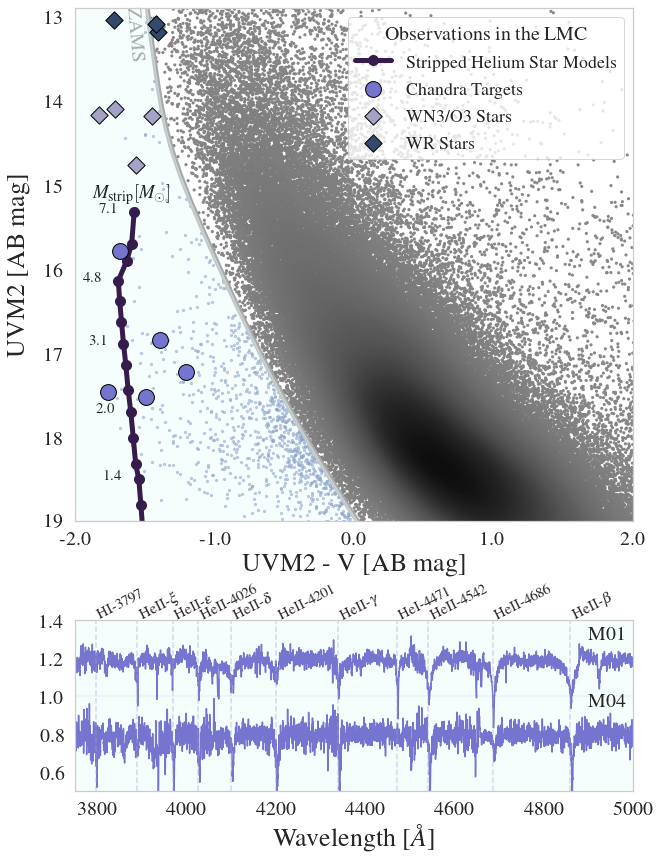

In [188]:
# Set plot:
f, (axes, bx) = plt.subplots(
    2, 1, figsize=(10, 15), gridspec_kw={"height_ratios": [3, 1]}
)

sns.set(style="whitegrid", font="serif")

# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)

# All Data:
plot_all = True
if plot_all:

    # More filtering:
    index_l = np.where(np.array(lx_cand) > -1.7)[0]

    axes.scatter(
        lx_ms,
        ly_ms,
        c=lz_ms,
        zorder=0,
        s=10,
        edgecolor="",
        cmap=truncate_colormap(plt.get_cmap("Greys"), 0.55, 0.95),
        label="",
    )
    axes.scatter(
        np.array(lx_cand)[index_l],
        np.array(ly_cand)[index_l],
        color=sky2,
        zorder=0,
        s=5,
        label="",
        alpha=0.5,
    )

# Shading
axes.fill_betweenx(
    zams_lmc_uvm2AB,
    np.repeat(-3, len(zams_lmc_uvm2AB)),
    zams_lmc_uvm2AB - zams_lmc_vAB,
    alpha=0.4,
    color="#e8fafc",
)

# ZAMS:
axes.plot(
    zams_lmc_uvm2AB - zams_lmc_vAB,
    zams_lmc_uvm2AB,
    linewidth=5,
    color="darkgray",
    zorder=0,
    label="",
)

# Stripped Stars Model:
axes.plot(
    she_lmc_uvm2AB - she_lmc_vAB,
    she_lmc_uvm2AB,
    linewidth=5,
    ms=10,
    marker="o",
    linestyle="-",
    label="Stripped Helium Star Models",
    zorder=1,
    color=purple1,
)

[
    axes.text(
        x + progenitor_sep,
        y,
        "%.1f" % float(string),
        fontweight="bold",
        fontsize=progenitorsize,
    )
    for x, y, string in zip(progenitor_lmc_x, progenitor_lmc_y, progenitor_lmc_label)
]


# Chandra Isolated Targets:
axes.scatter(
    iso_uvm2_v,
    iso_uvm2,
    marker="o",
    edgecolor="black",
    color=targetcolor,
    s=250,
    label="Chandra Targets",
    zorder=3,
)

# WN3/O3:
axes.scatter(
    wn_uvm2_v,
    wn_uvm2,
    marker="D",
    color=mediumblue,
    edgecolor="black",
    s=150,
    zorder=1,
    label="WN3/O3 Stars",
)

# WR LMC:
axes.scatter(
    wr_uvm2_v,
    wr_uvm2,
    marker="D",
    color=darkblue,
    edgecolor="black",
    s=150,
    zorder=1,
    label="WR Stars",
)


axes.text(
    progenitor_lmc_x[-1] - 0.3,
    progenitor_lmc_y[-1] - 0.15,
    r"$M_{\mathrm{strip}} [M_{\odot}]$",
    fontweight="bold",
    fontsize=progenitorsize + 4,
)

# Legend and Clean up:
axes.text(
    -1.65,
    13.5,
    "ZAMS",
    fontsize=textsize,
    zorder=1,
    weight="bold",
    rotation=-85,
    color="darkgray",
)


legend = axes.legend(prop={"size": legendsize, "weight": "bold"})
legend.set_title("Observations in the LMC", prop={"size": textsize})

axes.xaxis.label.set_size(labelsize)
axes.set_xlabel("UVM2 - V [AB mag]")

axes.yaxis.label.set_size(labelsize)
axes.set_ylabel("UVM2 [AB mag]", labelpad=ypad)

axes.grid(False)
axes.set_xlim(-2.0, 2)
axes.set_ylim(19.0, 13)
axes.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
axes.set_xticklabels([-2.0, -1.0, 0.0, 1.0, 2.0], fontsize=ticksize)

axes.set_yticks([19, 18, 17, 16, 15, 14, 13, 12.9])

axes.set_yticklabels([19, 18, 17, 16, 15, 14, 13], fontsize=ticksize)


# Spectra
lmc156c = ascii.read("Data/Spectra/lmc-m01_combined.helio.flm")
lmc2273 = ascii.read("Data/Spectra/lmc-m04.helio.flm")
lmc335 = ascii.read("Data/Spectra/lmc-m02.helio.flm")
lmc206 = ascii.read("Data/Spectra/lmc-obs-45446-206.helio.flm")

spec = lmc156c
spec2 = lmc2273

bx.plot(spec["col1"], spec["col2"] + 0.2, c=targetcolor)

bx.plot(spec2["col1"], spec2["col2"] - 0.2, c=targetcolor)

bx.set_xlim(3750, 5000)
bx.set_ylim(0.5, 1.4)

waves = [3797, 3889, 3969, 4026, 4101, 4201, 4339, 4471, 4542, 4686, 4860]
wavenames = [
    "HI-3797",
    r"HeII-$\xi$",
    r"HeII-$\epsilon$",
    "HeII-4026",
    r"HeII-$\delta$",
    "HeII-4201",
    r"HeII-$\gamma$",
    "HeI-4471",
    "HeII-4542",
    "HeII-4686",
    r"HeII-$\beta$",
]

[bx.axvline(x=lam, c=mediumblue, ls="dashed", alpha=0.4) for lam in waves]
bx.axhline(y=1, c=mediumblue, alpha=0.1)
bx.xaxis.label.set_size(labelsize)
bx.yaxis.label.set_size(labelsize)
bx.patch.set_facecolor("#e8fafc")
bx.patch.set_alpha(0.4)
bx.set_xlabel(r"Wavelength [$\AA$] ")
bx.grid(False)
# bx.set_ylabel("Normalized Intensity")

bx.text(4900, 1.3, "M01", fontsize=ticksize)
bx.text(4900, 0.95, "M04", fontsize=ticksize)
# Last adjustments
[bx.text(w, 1.41, n, rotation=27, fontsize=ticksize-5)
 for w, n in zip(waves, wavenames)]
bx.set_xticks([3800, 4000, 4200, 4400, 4600, 4800, 5000])
bx.set_xticklabels([3800, 4000, 4200, 4400, 4600,
                    4800, 5000], fontsize=ticksize)
bx.set_yticks([0.6, 0.8, 1., 1.2, 1.4])
bx.set_yticklabels([0.6, 0.8, 1., 1.2, 1.4], fontsize=ticksize)

# plt.suptitle("Observations in the Magellanic Clouds",size=titlesize,x=0.5,y=0.92,fontweight="bold")
plt.subplots_adjust(top=0.85, hspace=0.29)

plt.savefig("cmd.png", dpi=500)
plt.show()

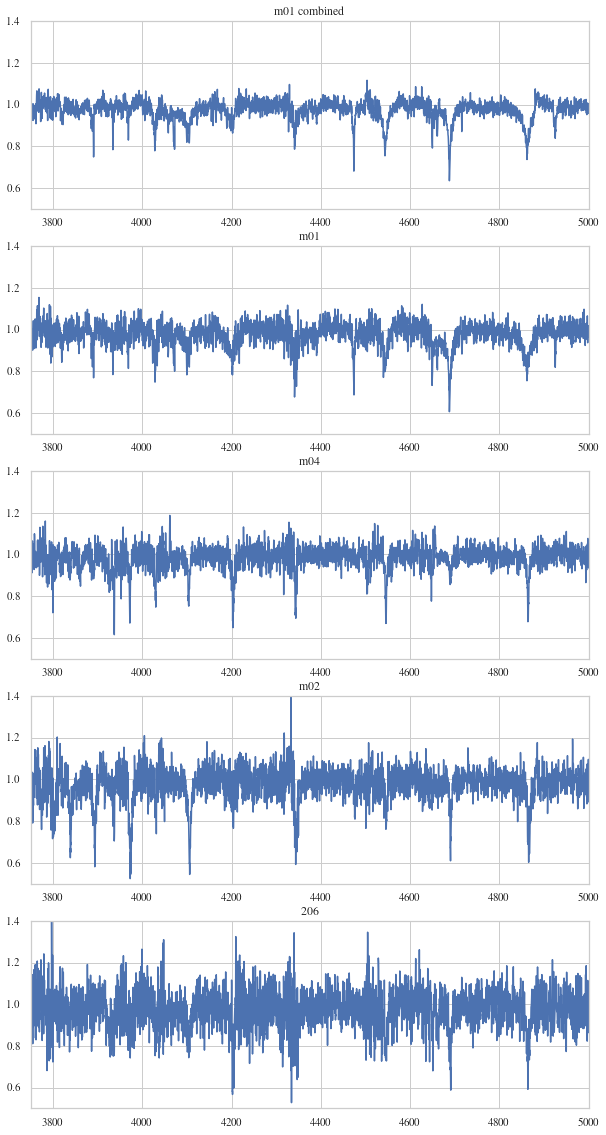

In [94]:
lmc156c = ascii.read("Data/Spectra/lmc-m01_combined.helio.flm")
lmc156 = ascii.read("Data/Spectra/lmc-m01.helio.flm")
lmc2273 = ascii.read("Data/Spectra/lmc-m04.helio.flm")
lmc335 = ascii.read("Data/Spectra/lmc-m02.helio.flm")
lmc206 = ascii.read("Data/Spectra/lmc-obs-45446-206.helio.flm")

spec = [lmc156c, lmc156, lmc2273, lmc335, lmc206]
filenames = ["m01 combined", "m01", "m04", "m02", "206"]

f, axes = plt.subplots(5, 1, figsize=(10, 20))

for ax, fname, s in zip(axes, filenames, spec):
    ax.set_title(fname)
    ax.plot(s["col1"], s["col2"])
    ax.set_xlim(3750, 5000)
    ax.set_ylim(0.5, 1.4)

plt.savefig("spectra.png")

(3500, 5000)

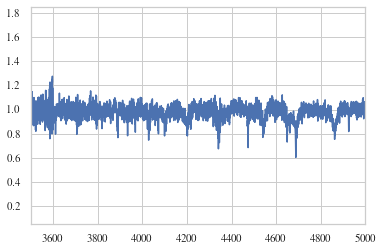

In [57]:
plt.plot(a['col1'],a['col2'])
plt.xlim(3500,5000)

In [55]:
a['col1']

3350.00871604
3350.26433632
3350.51995661
3350.77557689
3351.03119718
3351.28681746
3351.54243775
3351.79805803
3352.05367832
3352.3092986
3352.56491888


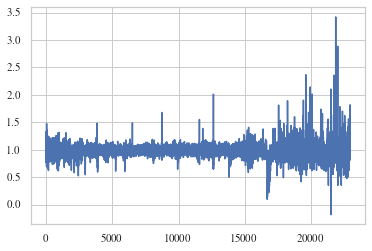

In [42]:
plt.plot(a[0].data)

In [43]:
a[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                22954 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2019-12-22T07:09:05' / Date FITS file was generated                  
IRAF-TLM= '2019-12-22T07:09:05' / Time of last modification                     
OBJECT  = 'lmc-m02 '           / Name of the object observed                    
BUNIT   = 'DU/PIXEL'                                                            
OBSERVER= 'Maria Drout'                / observer name                          
TELESCOP= 'Baade_Mag_1'                / telescope                              
SITENAME= 'LCO'             